## Μέρος 1ο - Ταξινόμηση με Συνελικτικά Νευρωνικά Δίκτυα

####  a. Υλοποιήστε και εκπαιδεύστε ένα CNN με δυο επίπεδα συνέλιξης με 32 και 64 φίλτρα διαστάσεων 3x3, και ένα fully connected επίπεδο με 128 νευρώνες πριν το επίπεδο εξόδου. Μετά από κάθε συνελικτικό επίπεδο χρησιμοποιείστε επίπεδο υποδειγματοληψίας με συνάρτηση μεγίστου (max pooling).

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from torchvision import datasets
from skimage import transform
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.autograd import Variable

import pandas as pd
import numpy as np
import seaborn as sn
from torch.utils.data import Dataset, DataLoader
#from vis_utils import *
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

Αρχικά, μετατρέπουμε σε tensors και φορτώνουμε το CIFAR10 dataset σε train_data και test_data.
To CIFAR10 είναι ένα dataset που αποτελείται από 60000 εικόνες που χωρίζονται σε 10 κατηγορίες: 
1. αεροπλάνο
2. αυτοκίνητο
3. πτηνό
4. γάτα
5. ελάφι
6. σκύλος
7. βάτραχος
8. άλογο
9. πλοίο
10. φορτηγό







In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Όπως παρατηρούμε, το σύνολο εκπαίδευσης αποτελείται από 50000 εικόνες και το σύνολο δοκιμής από 10000 εικόνες.

In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

Στη συνέχεια, θέτουμε seed=101 για να έχουμε τα ίδια αποτελέσματα σε κάθε εκτέλεση και φτιάχνουμε train_loader και test_loader για τα αντίστοιχα σύνολα εκπαίδευσης και δοκιμής με batch size = 10 

In [ ]:
#batch_size = 100
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size =10,shuffle =True)
test_loader = DataLoader(test_data,batch_size =10 ,shuffle =True)

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


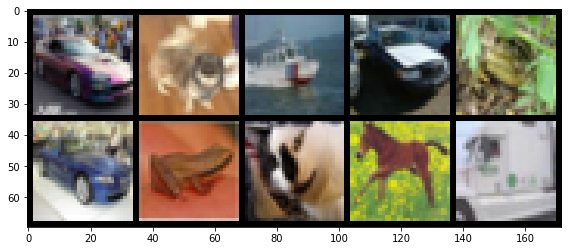

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


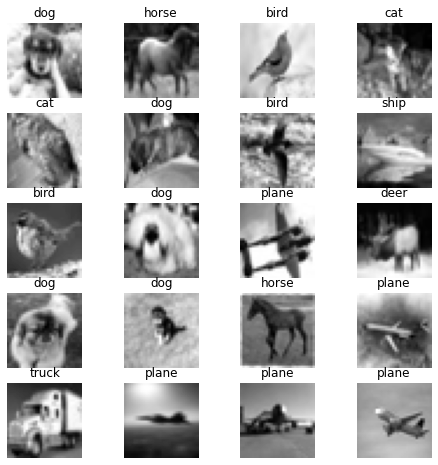

In [ ]:
labels_map = {0 : 'plane', 1 : 'car', 2 : 'bird', 3 : 'cat', 4 : 'deer', 5 : 'dog', 6 : 'frog',
              7 : 'horse', 8 : 'ship', 9 : 'truck'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_data));
    img = train_data[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


Παρατηρούμε, πως όντως οι εικόνες που φορτώσαμε έχουν διαστάσεις 32x32x3 όπου το 3 οφείλεται στο ότι είναι έγχρωμες εικόνες (3 κανάλια για RGB).

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

Ορίζουμε το αρχικό νευρωνικό δίκτο μέσω της class με όνομα CNN. Έχουμε 2 επίπεδα συνέλιξης. Το 1ο συνελικτικό επίπεδο έχει ως είσοδο 3 (3 κανάλια RGB) και ως έξοδο 32 νευρώνες, ένα φίλτρο διαστάσεων 3x3 και βήμα(stride=1). Το 2ο συνελικτικό επίπεδο έχει ως είσοδο την έξοδο του προηγογούμενου, δηλαδή 32, έξοδο 64 και ομοίως φίλτρο 3x3,stride=1. 
Το stride αναφέρεται ανά πόσα pixel μετακινείται το φίλτρο. 
Έπειτα, έχουμε ένα fully connected επίπεδο με είσοδο 6*6*64, έξοδο 128 νευρώνες και ένα τελικό επίπεδο fully connected επίπεδο με έισοδο την έξοδο του προηγούμενου δηλαδή 128 και έξοδο 10, όσες δηλαδή και οι κατηγορίες του dataset που πρέπει να προβλέπει το CNN. 
Αναλυτικά, η είσοδος του πρώτου fully connected layer υπολογίστηκε ως εξής: 
έχουμε είσοδο 32 στο 1ο συνελικτικό επίπεδο (32x32 διαστάσεις εικόνα), όμως δεν έχουμε zero padding άρα χάνουμε 2 pixel από κάθε πλευρά. Άρα, έχουμε 32-2 = 30 , και κάνουμε maxpool2 άρα 30/2 =15. Εφαρμόζουμε, και το 2ο συνελικτικό επίπεδο και πάλι λόγω έλλειψης zero padding χάνουμε 2 pixel άρα 15-2 = 13 και με maxpool2 13/2 = 6.5 , το οποίο στρογγυλοποιείται σε 6.



In [ ]:
class CNN(nn.Module):
    # In the constructor, we define the layers using the provided modules from the nn package.
    # A sequence of a layer, normalization, activation and pooling can be defined as a Sequential.
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3,1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64,3, 1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(6*6*64, 128)
        self.fc2 = nn.Linear(128,10)
        self.flatten = nn.Flatten()
    # The forward function is called on the Neural Network for a set of inputs,
    # and it passes that input through the different layers that have been defined
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)#view(out.size(0), -1) #  view function reshapes the output to match the dimensions required for the final layer
        out = self.fc1(out)
        out = self.fc2(out)
        return out

cnn = CNN() # create the instance of the ConvNet

Παρακάτω, τυπώνεται η δομή του δικτύου και βλέπουμε αναλυτικά τα παραπάνω συνελικτικά επίπεδα, τα fully connected τις συναρτήσεις ενεργοποίησης

In [ ]:
torch.manual_seed(101)
cnn = CNN()
cnn 

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

Παρακάτω, υπολογίζεται ο συνολικός αριθμός των παραμέτρων. Βλέπουμε, πως έχουμε 864 παραμέτρους αρχικά (3x3x3x32) και 32 bias. Στη συνέχεια έχουμε 18432 παραμέτρους (32x64x3x3) και 64 bias. Στο fc layer έχουμε 6*6*64(=2304)*128 = 294912 παραμέτρους και 128 bias. Τέλος έχουμε 1280 παραμέτρους 128 νευρώνες*10 κλάσεις και 10 bias. 

In [ ]:
for param in cnn.parameters():
    print(param.numel())

864
32
18432
64
294912
128
1280
10


Ορίζουμε συνάρτηση loss και εκτιμητή των Adam με learning rate =0.001

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001) 

Για την εκτέλεση της εκπαίδευσης και της δοκιμής εργαζόμαστε ώς εξής: 
1. ορίζουμε χρόνο για να δούμε πόση ώρα κάνει να τρέξει το δίκτυο μας.
2. Ορίζουμε τα epochs=10, και πίνακες για τα losses για εκπαίδευση,δοκιμή και για τα σωστά labels ομοίως.
3. Ορίζουμε την πρώτη επανάληψη για τα διάφορα epochs, το δίκτυο να εκπαιδεύεται με τα αντίστοιχα δεδομένα για κάθε batch, να υπολογίζονται τα predicted labels, η απώλεια(loss) μέσω του criterion, και αν τα predicted labels είναι ίσα με τα πραγματικά labels αποθηκεύονται στον πίνακα train_correct. Στη συνέχεια, έχουμε την ενημέρωση των παραμέτρων: μηδενίζουμε , μεταφέρουμε προς τα πίσω τα losses και ορίζουμε το step. 
4. Τυπώνουμε τα αποτελέσματα ανα 1000 batches σε κάθε epoch
5. Ορίζουμε ομοίως για τα batches δοκιμής (testing) 
6. Τυπώνουμε τον χρόνο που έτρεξε το δίκτυο

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = cnn(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    total = 0
    with torch.no_grad():
       for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
         y_val = cnn(X_test)

            # Tally the number of correct predictions
         predicted = torch.max(y_val.data, 1)[1] 
         tst_corr += (predicted == y_test).sum()
         total += y_test.size(0)  
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)
print('Test Accuracy of the model is: %.4f %%' % (100 * tst_corr / total))       
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed    

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.77114868  accuracy:  37.210%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.25811839  accuracy:  42.520%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 0.86099082  accuracy:  45.817%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 0.96207619  accuracy:  48.045%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.68445665  accuracy:  49.848%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.95397711  accuracy:  60.030%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 0.86747360  accuracy:  60.310%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.84209025  accuracy:  60.607%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.96090651  accuracy:  60.935%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.27125156  accuracy:  61.278%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.31936014  accuracy:  65.820%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.23857760  accuracy:  64.720%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.04412806  accuracy:  64.687%
epoch:  2  b

Παρακάτω, παρατίθεται το διάγραμμα της ακρίβειας, τόσο για το test όσο και για το train. Όπως είναι αναμενόμενο, η ακρίβεια στην εκπαίδευση αποδίδει καλύτερα καθώς το δίκτυο εκπαιδεύεται αλλά η ακρίβεια στη δοκιμή είναι χαμηλότερη καθώς μόλις βλέπει καινούργια δεδομένα δυσκολεύεται. 

Η συνολική ακρίβεια που έχει το δίκτυο στο test dataset είναι 67.78%, ένα αρκετά καλό ποσοστό για το αρχικό CNN μας, καθώς έχουμε πολλα δεδομένα. 

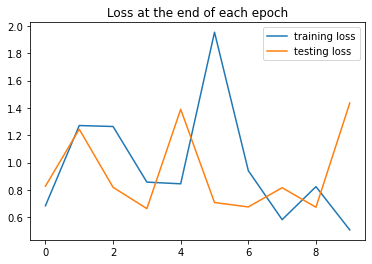

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'testing loss')
plt.title('Loss at the end of each epoch')
plt.legend();

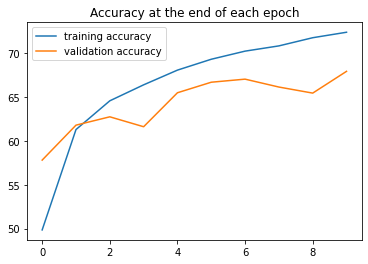

In [ ]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(5780), tensor(6178), tensor(6273), tensor(6160), tensor(6547), tensor(6667), tensor(6702), tensor(6612), tensor(6543), tensor(6791)]

Test accuracy: 67.910%


Παρακάτω, παρατίθεται και ο πίνακας σύγχυσης ώστε να δούμε πως ταξινομεί το δίκτυο μας τα labels μας. Όπως αναμένεται, έχουμε μεγάλες τιμές στη κύρια διαγώνιο (ίδια αντικείμενα) ενώ βλέπουμε πως το δίκτυο μας  δυσκολεύεται να ξεχωρίσει πανομοιότυπα αντικείμενα όπως αυτοκίνητο από φορτηγό ή σκύλο από γάτα , σκύλο από άλογο ή σκύλο από βάτραχο

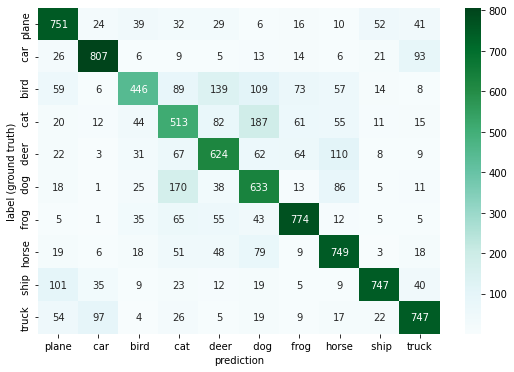

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = cnn(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d",cmap = 'BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

 ### b. Εισάγετε επίπεδα κανονικοποίησης των δεδομένων (batch normalization) μετά τα συνελικτικά επίπεδα. Τι επίδραση έχει στην ακρίβεια; 

Όλα τα βήματα παραμένουν ίδια με το ερώτημα α, με την μόνη διαφορά πως μετά από τα 2 συνελικτικά επίπεδα προστίθεται ένα επίπεδο κανονικοποίησης των δεδομένων, δηλαδή μέση τιμή 0 και τυπική απόκλιση 1. Πρακτικά, στα επίπεδα του νευρωνικού εφαρμόζουμε νορμαλισμό ώστε να αυξήσουμε την ταχύτητα της εκπαίδευσης. 

In [ ]:
class CNN2(nn.Module):
    # In the constructor, we define the layers using the provided modules from the nn package.
    # A sequence of a layer, normalization, activation and pooling can be defined as a Sequential.
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64,3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(6*6*64, 128)
        self.fc2 = nn.Linear(128,10)
        self.flatten = nn.Flatten()
    # The forward function is called on the Neural Network for a set of inputs,
    # and it passes that input through the different layers that have been defined
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)#view(out.size(0), -1) #  view function reshapes the output to match the dimensions required for the final layer
        out = self.fc1(out)
        out = self.fc2(out)
        return out

cnn2 = CNN2() # create the instance of the ConvNet

In [ ]:
torch.manual_seed(101)
cnn2 = CNN2()
cnn2 

CNN2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(cnn2.parameters(), lr=0.001) 

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses2 = []
test_losses2 = []
train_correct2 = []
test_correct2 = []

for i in range(epochs):
    trn_corr2 = 0
    tst_corr2 = 0
    
    # Run the training batches
    for b2, (X_train, y_train) in enumerate(train_loader):
        b2+=1
        
        # Apply the model
        y_pred2 = cnn2(X_train)
        loss2 = criterion(y_pred2, y_train)
 
        # Tally the number of correct predictions
        predicted2 = torch.max(y_pred2.data, 1)[1]
        batch_corr2 = (predicted2 == y_train).sum()
        trn_corr2 += batch_corr2
        
        # Update parameters
        optimizer.zero_grad()
        loss2.backward()
        optimizer.step()
        
        # Print interim results
        if b2%1000 == 0:
            print(f'epoch: {i:2}  batch: {b2:4} [{10*b2:6}/50000]  loss: {loss2.item():10.8f}  \
accuracy: {trn_corr2.item()*100/(10*b2):7.3f}%')
        
    train_losses2.append(loss2)
    train_correct2.append(trn_corr2)
    total2 = 0    
    # Run the testing batches
    with torch.no_grad():
        for b2, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val2 = cnn2(X_test)

            # Tally the number of correct predictions
            predicted2 = torch.max(y_val2.data, 1)[1] 
            tst_corr2 += (predicted2 == y_test).sum()
            total2 += y_test.size(0)
    loss2 = criterion(y_val2, y_test)
    test_losses2.append(loss2)
    test_correct2.append(tst_corr2)
print('Test Accuracy of the model is: %.4f %%' % (100 * tst_corr2 / total2))         
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.58387458  accuracy:  41.040%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.55211520  accuracy:  46.260%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 0.66217667  accuracy:  49.607%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 0.69782144  accuracy:  51.945%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.48732838  accuracy:  53.888%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.74996483  accuracy:  63.150%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 0.91641653  accuracy:  63.755%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.43040401  accuracy:  64.323%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.92863816  accuracy:  64.688%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.75230730  accuracy:  65.050%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.34727597  accuracy:  69.580%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.11401057  accuracy:  69.190%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.72593093  accuracy:  69.213%
epoch:  2  b

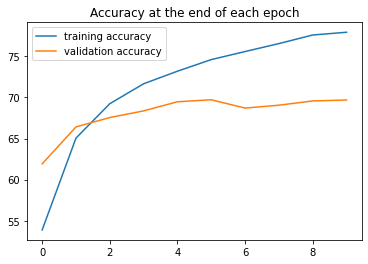

In [ ]:
plt.plot([t/500 for t in train_correct2], label='training accuracy')
plt.plot([t/100 for t in test_correct2], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

Παρατηρούμε, και στο διάγραμμα παραπάνω πως έχουμε καλύτερη απόδοση στο δίκτυο καθώς και καλύτερη ακρίβεια στις δοκιμές στα 70.34% πλέον. Επίσης, παρατηρούμε πως η ακρίβεια κατά την εκπαίδευση "πιάνει" πολύ μεγαλύτερο ποσοστό πολύ πιο γρήγορα σε σχέση με το αρχικό μοντέλο. 

In [ ]:
print(test_correct2) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct2[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(6192), tensor(6641), tensor(6755), tensor(6836), tensor(6947), tensor(6971), tensor(6870), tensor(6905), tensor(6957), tensor(6968)]

Test accuracy: 69.680%


### c. Κάνετε τις κατάλληλες τροποποιήσεις ώστε να μετατρέψετε την αρχιτεκτονική του δικτύου που υλοποιήσατε σε fully convolutional (χωρίς fully connected layers) χωρίς να μεταβληθεί σημαντικά ο αριθμός των παραμέτρων του δικτύου.

In [ ]:
class CNN3(nn.Module):
    # In the constructor, we define the layers using the provided modules from the nn package.
    # A sequence of a layer, normalization, activation and pooling can be defined as a Sequential.
    def __init__(self):
        super(CNN3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3,1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64,3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size =(6,6),stride =1),
            
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128,10, kernel_size =(1,1),stride =1),
            
        )
        self.flatten = nn.Flatten()
    # The forward function is called on the Neural Network for a set of inputs,
    # and it passes that input through the different layers that have been defined
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
                          #view(out.size(0), -1) #  view function reshapes the output to match the dimensions required for the final layer
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.flatten(out)   
        return out

cnn3 = CNN3() # create the instance of the ConvNet

In [ ]:
torch.manual_seed(101)
cnn3 = CNN3()
cnn3 

CNN3(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
  )
  (layer4): Sequential(
    (0): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(cnn3.parameters(), lr=0.001) 

In [ ]:
for param in cnn3.parameters():
    print(param.numel())

864
32
32
32
18432
64
64
64
294912
128
1280
10


In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses3 = []
test_losses3 = []
train_correct3 = []
test_correct3 = []

for i in range(epochs):
    trn_corr3 = 0
    tst_corr3 = 0
    
    # Run the training batches
    for b3, (X_train, y_train) in enumerate(train_loader):
        b3+=1
        
        # Apply the model
        y_pred3 = cnn3(X_train)
        loss3 = criterion(y_pred3, y_train)
 
        # Tally the number of correct predictions
        predicted3 = torch.max(y_pred3.data, 1)[1]
        batch_corr3 = (predicted3 == y_train).sum()
        trn_corr3 += batch_corr3
        
        # Update parameters
        optimizer.zero_grad()
        loss3.backward()
        optimizer.step()
        
        # Print interim results
        if b3%1000 == 0:
            print(f'epoch: {i:2}  batch: {b3:4} [{10*b3:6}/50000]  loss: {loss3.item():10.8f}  \
accuracy: {trn_corr3.item()*100/(10*b3):7.3f}%')
        
    train_losses3.append(loss3)
    train_correct3.append(trn_corr3)
        
    # Run the testing batches
    total3 = 0
    with torch.no_grad():
        for b3, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val3 = cnn3(X_test)

            # Tally the number of correct predictions
            predicted3 = torch.max(y_val3.data, 1)[1] 
            tst_corr3 += (predicted3 == y_test).sum()
            total3 += y_test.size(0)
    loss3 = criterion(y_val3, y_test)
    test_losses3.append(loss3)
    test_correct3.append(tst_corr3)
print('Test Accuracy of the model is: %.4f %%' % (100 * tst_corr3 / total3))          
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed    

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.40263116  accuracy:  41.210%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.55423701  accuracy:  46.265%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 0.66948140  accuracy:  49.720%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 0.68689108  accuracy:  51.940%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.46538630  accuracy:  53.816%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.77510679  accuracy:  63.300%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.04258323  accuracy:  63.850%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.43842754  accuracy:  64.397%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.82058382  accuracy:  64.703%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.00207877  accuracy:  64.994%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.49496913  accuracy:  69.540%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.32617307  accuracy:  68.815%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.66640282  accuracy:  68.723%
epoch:  2  b

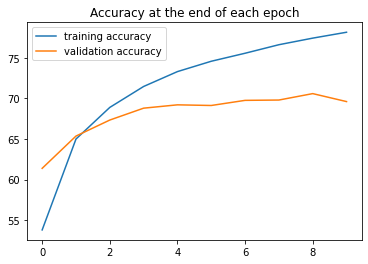

In [ ]:
plt.plot([t/500 for t in train_correct3], label='training accuracy')
plt.plot([t/100 for t in test_correct3], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [ ]:
print(f'Test accuracy: {test_correct3[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

Test accuracy: 69.600%


### d. Πειραματιστείτε και προτείνετε ένα CNN δικής σας έμπνευσης που να βελτιστοποιεί την ακρίβεια ταξινόμησης στο test set χωρίς ενδείξεις overfitting

Το ερώτημα δ αναλύεται σε διαφορετικά αρχεία. Συγκεκριμένα στο densenet_final που έδωσε και την υψηλότερη ακρίβεια, το resnet και λόγω σύγκρισης πραγματοποιήθηκε και train με ένα pre trained.